<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br> 
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Escreva uma breve descrição do problema.

## 2\. Pacotes e bibliotecas

In [1]:
# IMPORTAÇÃO DOS PACOTES NECESSÁRIOS

import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
from matplotlib.pyplot import figure

## 3\. Exploração de dados

In [ ]:
# faça o código de exploração de dados:
#
# - coleta de dados;
# - wrangling da estrutura;
# - exploração do schema;
# - etc.

In [2]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json 

In [3]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# DADOS BRUTOS

deliveries_df = pd.DataFrame(data)

# NORMALIZANDO COLUNA ORIGIN

hub_origin_df = pd.json_normalize(deliveries_df["origin"])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

# NORMALIZANDO COLUNA DELIVERIES

deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

In [4]:
# SCHEMA 

deliveries_df.head(n=5)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [5]:
deliveries_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

In [ ]:
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [ ]:
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


## 4\. Manipulação

In [ ]:
# faça o código de manipulação de dados:
#
# - enriquecimento;
# - controle de qualidade;
# - etc.

In [6]:
# AGREGANDO INFORMAÇÕES DE ENDEREÇO

hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [7]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")


In [8]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str) 
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)


hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))


hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)


hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]


deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]


In [9]:
# VISUALIZAÇÃO DO DATA FRAME

deliveries_df.head(5)

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


## 5\. Visualização

In [12]:
# faça o código de visualização de dados:
#
# - produza pelo menos duas visualizações;
# - adicione um pequeno texto com os insights encontrados;
# - etc.


vol_ttl_city = deliveries_df[['hub_city','delivery_size']].groupby('hub_city').agg('sum').reset_index()


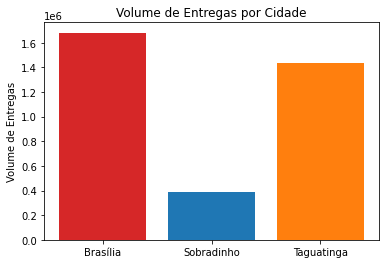

<Figure size 1440x720 with 0 Axes>

In [11]:

fig, ax = plt.subplots()

#bar_labels = ['red', 'blue', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

ax.bar(vol_ttl_city['hub_city'], vol_ttl_city['delivery_size'], color=bar_colors)

ax.set_ylabel('Volume de Entregas')
ax.set_title('Volume de Entregas por Cidade')
#ax.legend(title='Cidades')
plt.figure(figsize=(20,10))
plt.show()